<a href="https://colab.research.google.com/github/eluyutao/goemotion/blob/main/Hyperparameter_Tuning_%26_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!kill 718

/bin/bash: line 0: kill: (718) - No such process


In [ ]:
%reload_ext tensorboard

# %tensorboard --logdir /tmp/tb_logs

# MMAI 894 - SENTIMENT ANALYSIS based on Exercise 3
## Transfer learning with DistilBert
The goal of this excercise is to build a text classifier using the pretrained DistilBert published by HuggingFace. You will be doing this using the Glue/CoLA dataset (https://nyu-mll.github.io/CoLA/).



In [56]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install keras_tuner
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds
import keras_tuner as kt

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# My additions
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
#from transformers import DefaultDataCollator

In [57]:
# From Lucas, needed for preprocessing
!pip install emot

import pandas as pd
import emot, re
from sklearn.model_selection import train_test_split
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
pd.set_option("display.max_columns", 99)

# Get the GOEMOTIONS Datasets

In [28]:
# ! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
# ! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
# ! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
goemotions_1 = pd.read_csv('goemotions_1.csv')
goemotions_2 = pd.read_csv('goemotions_2.csv')
goemotions_3 = pd.read_csv('goemotions_3.csv')
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames, ignore_index=True)

In [58]:
print(df.shape)
df.head(2)

(211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Start Data Preparation

In [59]:
%%time
# emotion label columns
lb_col = df.columns[9:]
print(f'Entire dataset: {df.shape}')
# remove examples that were very unclear. They do not have any emotions labels
df2 = df[~df['example_very_unclear']].copy()
print(f'{df2.shape[0]} rows left after removing records with unclear emotions')
# Sum the emotions together because there are different raters
df2 = df2[['text']+list(lb_col)].groupby(['text']).sum().reset_index()
print(f'{df2.shape[0]} rows left after deduping on text and id columns')
# keep records where there are at least two agreeing emotion labels
df2['at_least_2_agree'] = df2[lb_col].apply(lambda x: x.max(), axis=1)
df2 = df2[df2.at_least_2_agree >= 2]
#df2 = df2.replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1}, inplace=False)
#df_clean = df2.drop('at_least_2_agree', axis=1)
#print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')
#df2 = df2[df2.at_least_2_agree >= 2]
print(df2.at_least_2_agree.unique())

Entire dataset: (211225, 37)
207814 rows left after removing records with unclear emotions
57730 rows left after deduping on text and id columns
[ 2  3  4  5  7  6 12 13 14  8 17  9 10 15 33 11 45 22]
CPU times: user 2.9 s, sys: 200 ms, total: 3.1 s
Wall time: 3.11 s


In [60]:
for col in df2.columns[1:]:
    df2[col] = df2[col].apply(lambda x: 0 if x <= 1 else 1)

# df2 = df2.replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1}, inplace=False)
df_clean = df2.drop('at_least_2_agree', axis=1)
print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')

print(df_clean.shape)
df_clean.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


53994 rows left after removing records without having at least two raters agreeing on the emotion
(53994, 29)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [61]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
            #print(f'{orig} -> {text}', '\n')
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].split()))
            #print(f'{orig} -> {text}', '\n')
    return text

In [62]:
%%time
print('-------replacing emoji with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emojis(x))
print('-------replacing emoticon with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emoticons(x))

-------replacing emoji with text---------
-------replacing emoticon with text---------
CPU times: user 8.54 s, sys: 0 ns, total: 8.54 s
Wall time: 8.55 s


In [63]:
# Based on experimentation, the emotions which are classified best have at
# least 2500 instances in the dataset.  

# The following classes are HEAVILY underrepresented in the data:
#   Emotion        Count
#   --------------------
#   grief          97
#   pride          142
#   relief         182
#   nervousness    208
#   embarrassment	 374

# df_clean.drop(columns=['grief', 'pride', 'relief', 'nervousness', 'embarrassment'], inplace=True)
labels_to_drop = ['grief', 'pride', 'relief', 'nervousness', 'embarrassment']
for col in df_clean.columns[1:]:
  if col in labels_to_drop:
    df_clean[col] = 0
df_clean['sum_label'] = df_clean[1:].sum(axis=1)
df_clean = df_clean[df_clean.sum_label > 0]
df_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(53425, 30)

In [64]:
df_clean.drop(labels=labels_to_drop+['sum_label'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
print(df_clean.shape)
X = df_clean['text']
y = df_clean.iloc[:,1:]
y.head(2)

(53425, 24)


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,excitement,fear,gratitude,joy,love,optimism,realization,remorse,sadness,surprise,neutral
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(y_train.shape)

(48082, 23)


In [67]:
# train_data = pd.merge(X_train, y_train, how='inner', left_index=True, right_index=True)
# train_data.shape

In [68]:
# # # => Brute force oversample these until ~2500 instances
# def gross_up_class(df, class_name):
#     orig_shape = df[class_name].sum()
#     print(f"{class_name} originally have {orig_shape} 1's")
#     if orig_shape < 2500:
#       # df_temp = pd.DataFrame()
#       n = 2500 - df[df[class_name] == 1].shape[0]
#       print(f'need to oversample {n} instances')
#       replace = True if n > orig_shape else False
#       smpl = df[df[class_name] == 1].sample(n, replace = replace)
#       df = pd.concat([df, smpl], ignore_index=True)
#       print(class_name, df[class_name].sum(), '\n')
#     else:
#       print("no need to oversample current class'\n'")
#     return df

# for col in y_train.columns:
#   train_data = gross_up_class(train_data, col)


In [69]:
# # The following class is HEAVILY overrepresented in the data:
# #   Emotion        Count
# #   --------------------
# #   neutral	       17742
# #
# # => Want to drop ~10k instances, but only those purely labeled as neutral

# keep_neutral_sample = 7000
# train_data['num_senti'] = train_data.iloc[:,1:].sum(axis=1)
# train_data.loc[(train_data['num_senti'] == 1) & (train_data['neutral'] == 1), 'only_neutral'] = 1
# print(f'only neutral: {train_data[train_data.only_neutral==1].shape}')
# neutral_sample = train_data[train_data.only_neutral==1].sample(keep_neutral_sample)
# train_data_no_only_neutral = train_data[train_data.only_neutral != 1].copy()
# train_data = pd.concat([train_data_no_only_neutral, neutral_sample], ignore_index=True)
# print(train_data.shape)
# print([f'{col}: {train_data[col].sum()}' for col in y_train.columns])

In [70]:
# train_data.head(2)

In [71]:
# train_data.drop(labels=['num_senti','only_neutral'], inplace=True, axis=1)
# train_data.shape

In [72]:
# X_train = train_data.text
# y_train = train_data.iloc[:, 1:]

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=2)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (42071,)
X_val shape: (6011,)
X_test shape: (5343,)
y_train shape: (42071, 23)
y_val shape: (6011, 23)
y_test shape: (5343, 23)


In [74]:
# # XXX Come back later and go from Series to list. Skip the dataframe step
df_X_train = X_train.to_frame()
df_X_val   = X_val.to_frame()
df_X_test  = X_test.to_frame()

Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [75]:
def make_y_a_numpy_array(df):
  # Initially thoughts I needed lists, but this is simple df to numpy
  y = df.to_numpy()
  return y


def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    batch_size = 128
    input_ids = []
    attention_mask = []

    temp = text['text'].to_list()
    for count in range(0, len(text), batch_size):
      batch_text = temp[count:count+batch_size]
      # have to truncate b/c was resulting in a non-rectangular shape
      output = dbert_tokenizer(batch_text,
                             padding='max_length',
                             return_attention_mask=True,
                             max_length=256, #96  # was 512, but took waay too long
                             truncation=True
                             )
      input_ids.extend(output['input_ids'])
      attention_mask.extend(output['attention_mask'])

    # Try switching everything to numpy arrays
    input_ids = np.array(input_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
np_array_y_train = make_y_a_numpy_array(y_train)
np_array_y_val   = make_y_a_numpy_array(y_val)
np_array_y_test  = make_y_a_numpy_array(y_test)

train_input, train_mask = encode_text(df_X_train)
val_input, val_mask = encode_text(df_X_val)
test_input, test_mask = encode_text(df_X_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

# Modelling

## Build and Train Model

Resources:
- BERT paper https://arxiv.org/pdf/1810.04805.pdf
- DistilBert paper: https://arxiv.org/abs/1910.01108
- DistilBert Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [76]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        # TODO: build the model, with the option to freeze the parameters in distilBERT
        # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
        # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
        # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
        # Hint 3: double check that your number of parameters make sense
        # Hint 4: carefully consider your final layer activation and loss function

        # Refer to https://keras.io/api/layers/core_layers/input/
        base_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        trainable=False

        params= {
          "max_seq_len":256,
          "layer_dropout":0.25,
          # "learning":4e-4,
          "random_seed":91
          }

        max_seq_len = params['max_seq_len']
        layer_dropout = params['layer_dropout']
        random_seed = params['random_seed']

        initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

        inputs = Input(shape=(max_seq_len,), 
                      name='input_ids', 
                      dtype='int32')
        masks  = Input(shape=(max_seq_len,), 
                      name='input_attention', 
                      dtype='int32')

        base_model.trainable = trainable

        dbert_output = base_model(inputs, attention_mask=masks)
        # dbert_last_hidden_state gets you the output encoding for each of your tokens.
        # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
        # which can be used to build a sentence classification network
        dbert_last_hidden_state = dbert_output.last_hidden_state


        # Any additional layers should go here
        # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
        cls_token = dbert_last_hidden_state[:, 0, :]
        X = tf.keras.layers.BatchNormalization()(cls_token)

        hp_units_1 = hp.Int('units1', min_value=128, max_value=192, step=32)
        X = tf.keras.layers.Dense(hp_units_1, activation='relu')(X)
        X = tf.keras.layers.Dropout(layer_dropout)(X)

        my_output = X
        probs = Dense(23, #28, 
                      #activation='softmax',
                      activation='sigmoid',
                      kernel_initializer=initial_weights,  
                      kernel_constraint=None,
                      bias_initializer='zeros'
                      )(my_output)

        model = keras.Model(inputs=[inputs, masks], outputs=probs)
        print(model.summary())

        metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
            tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
            keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
            keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
            keras.metrics.CategoricalAccuracy(name='val_accuracy')]

        loss = tfa.losses.SigmoidFocalCrossEntropy()

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]) #################
        model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss=loss,
                  metrics=metrics)

        return model
    def fit(self, hp, model, *args, **kwargs):
        # TODO: train the model
        # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 128]),
            **kwargs)

# dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


# model = build_model(dbert_model, params=params)

In [97]:
tuner = kt.Hyperband(MyHyperModel(),
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory="/tmp/tb")
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                         

In [98]:
import datetime
import os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# log_dir = "/tmp/tb_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/tmp/tb_logs", histogram_freq=1)

In [100]:
tuner.search(x = [train_model_inputs_and_masks["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
#         batch_size=128,
        epochs=3,
        verbose=2,
        validation_data=([val_model_inputs_and_masks["inputs"],
                                          val_model_inputs_and_masks["masks"]],
                                         y_val),
        callbacks=[stop_early, tensorboard_callback])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 17 Complete [01h 17m 38s]
val_accuracy: 0.4674478769302368

Best val_accuracy So Far: 0.4674478769302368
Total elapsed time: 06h 01m 23s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
128               |160               |units1
0.001             |0.001             |learning_rate
32                |32                |batch_size
15                |15                |tuner/epochs
5                 |5                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0013              |0012              |tuner/trial_id



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

KeyboardInterrupt: ignored

In [101]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [114]:
# print the best 50 trials
tuner.results_summary(50)

Results summary
Results in /tmp/tb/untitled_project
Showing 50 best trials
Trial summary
Hyperparameters:
units1: 160
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
batch_size: 32
tuner/trial_id: 0012
Score: 0.4674478769302368
Trial summary
Hyperparameters:
units1: 160
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
batch_size: 32
tuner/trial_id: 0000
Score: 0.43966153264045715
Trial summary
Hyperparameters:
units1: 128
learning_rate: 0.001
batch_size: 32
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.4373321235179901
Trial summary
Hyperparameters:
units1: 160
learning_rate: 0.001
batch_size: 128
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0002
Score: 0.42694494128227234
Trial summary
Hyperparameters:
units1: 160
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 

In [121]:

print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense
layer is {best_hps.get('units1')}, best batch_size is {best_hps.get('batch_size')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the best epochs is {best_hps.get('tuner/epochs')}.
""")


The hyperparameter search is complete. The optimal number of units in the first dense
layer is 160, best batch_size is 32, the optimal learning rate for the optimizer
is 0.001, the best epochs is 15.



## Ad-hoc Analysis: Find model performance per "number of emotions" groups

In [116]:
def build_model(base_model, trainable=False, params={}):

    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

    inputs = Input(shape=(max_seq_len,), 
                   name='input_ids', 
                   dtype='int32')
    masks  = Input(shape=(max_seq_len,), 
                   name='input_attention', 
                   dtype='int32')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    dbert_last_hidden_state = dbert_output.last_hidden_state


    # Any additional layers
    cls_token = dbert_last_hidden_state[:, 0, :]
    X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(192, activation='relu')(X)
    X = tf.keras.layers.Dropout(layer_dropout)(X)

    my_output = X
    probs = Dense(23, #28, 
                  #activation='softmax',
                  activation='sigmoid',
                  kernel_initializer=initial_weights,  
                  kernel_constraint=None,
                  bias_initializer='zeros'
                  )(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params= {
        "max_seq_len":256,
        "layer_dropout":0.25,
        "learning":0.001,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                         

In [117]:
def compile_model(model):
    # Metrics
    #     "Hamming loss is the fraction of wrong labels to the total number of labels.
    #      In multi-class classification, hamming loss is calculated as the hamming 
    #      distance between y_true and y_pred. In multi-label classification, hamming
    #      loss penalizes only the individual labels.""
    metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
               tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
               keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
               keras.metrics.CategoricalAccuracy()]

    # Loss
    #loss = keras.losses.SparseCategoricalCrossentropy()
    
    # Switch to Categorical to support multi-class classification
    #    loss = keras.losses.CategoricalCrossentropy()
    # Try binary cross-entropy and switch model to sigmoid
    #    loss = keras.losses.BinaryCrossentropy()
    # Use a new one from TFA

    loss = tfa.losses.SigmoidFocalCrossEntropy()

    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), 
                  loss=loss,
                  metrics=metrics)

    return model

model = compile_model(model)

In [118]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):

    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"]],
                                         y_val),
                        verbose=2)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=32, num_epochs=3)

Epoch 1/3
1315/1315 - 463s - loss: 0.4324 - hamming-mc: 0.2464 - hamming-ml: 0.0579 - Cat-CE: 2.8121 - Bin-CE: 0.7645 - categorical_accuracy: 0.3490 - val_loss: 0.2948 - val_hamming-mc: 0.0765 - val_hamming-ml: 0.0443 - val_Cat-CE: 2.5040 - val_Bin-CE: 0.7199 - val_categorical_accuracy: 0.4552 - 463s/epoch - 352ms/step
Epoch 2/3
1315/1315 - 456s - loss: 0.3149 - hamming-mc: 0.1136 - hamming-ml: 0.0465 - Cat-CE: 2.5763 - Bin-CE: 0.7372 - categorical_accuracy: 0.4275 - val_loss: 0.2868 - val_hamming-mc: 0.0907 - val_hamming-ml: 0.0438 - val_Cat-CE: 2.4536 - val_Bin-CE: 0.7325 - val_categorical_accuracy: 0.4651 - 456s/epoch - 347ms/step
Epoch 3/3
1315/1315 - 455s - loss: 0.3038 - hamming-mc: 0.0940 - hamming-ml: 0.0453 - Cat-CE: 2.5346 - Bin-CE: 0.7380 - categorical_accuracy: 0.4426 - val_loss: 0.2823 - val_hamming-mc: 0.0456 - val_hamming-ml: 0.0429 - val_Cat-CE: 2.4702 - val_Bin-CE: 0.7235 - val_categorical_accuracy: 0.4821 - 455s/epoch - 346ms/step


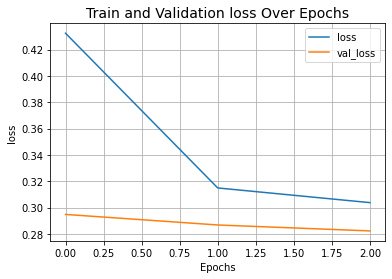

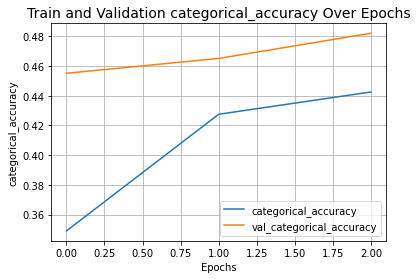

In [119]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [120]:
test_df = pd.DataFrame()
labels = []
predicts = []
iteration = []

def eval_model(model, inputs_and_masks, label):

    test_scores = model.evaluate(x = [inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]],
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)
    
    # collect the first 30 predictions looking for incorrect ones
    predictions = model.predict([inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]])
    for i in range(len(predictions)):
      labels.append(label[i])
      predicts.append(predictions[i])
      iteration.append(i)

    test_df['Labels'] = labels
    test_df['Predictions'] = predicts
    test_df['Iteration'] = iteration
    return test_loss, test_metrics

test_loss, test_metrics = eval_model(model, test_model_inputs_and_masks, np_array_y_test)

167/167 - 47s - loss: 0.2818 - hamming-mc: 0.0421 - hamming-ml: 0.0430 - Cat-CE: 2.4726 - Bin-CE: 0.7244 - categorical_accuracy: 0.4754 - 47s/epoch - 284ms/step
Test loss: 0.28176388144493103
Test accuracy: 0.042111173272132874


In [129]:
X_test.shape

(5343,)

In [128]:
len(test_model_inputs_and_masks['inputs'])

5343

In [122]:
rounded_pred = []

test_df['Rounded_Pred'] = test_df['Predictions'].copy()

for i in range(test_df.shape[0]):
  arr = test_df['Rounded_Pred'][i]
  arr[arr <= 0.2] = 0
  arr[arr > 0.2] = 1
  rounded_pred.append(arr)

test_df['Rounded_Pred'] = rounded_pred
test_df.head()

,Labels,Predictions,Iteration,Rounded_Pred
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",2,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",4,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ..."


In [123]:
y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)

f1 = tfa.metrics.F1Score(num_classes=23, threshold=0.5) # was 28 classes
f1.update_state(y_true, y_pred)
print("\nF1 Score: ", f1.result().numpy())


F1 Score:  [0.37610435 0.41321045 0.2778731  0.21727516 0.2178899  0.29281765
 0.29021373 0.4371909  0.22996515 0.15887852 0.2532189  0.16833097
 0.18252428 0.19624218 0.6346556  0.27209306 0.47706422 0.2670157
 0.13963039 0.37007874 0.30527815 0.1980198  0.56077695]


In [125]:
avg_f1 = f1.result().numpy().mean()
avg_f1

0.30158034

In [ ]:
# perf_report = pd.DataFrame([prcsn, rcl, f1.result().numpy()], columns=y_train.columns).T
# perf_report.rename(columns={0:'Precision', 1:'Recall', 2:'F1'}, inplace=True)
# perf_report

,Precision,Recall,F1
admiration,0.247475,0.890909,0.387352
amusement,0.300234,0.815873,0.438941
anger,0.156309,0.809756,0.262036
annoyance,0.137457,0.771704,0.233350
approval,0.137382,0.764543,0.232911
caring,0.125385,0.807947,0.217082
confusion,0.149948,0.819209,0.253497
curiosity,0.243562,0.919028,0.385072
desire,0.081448,0.710526,0.146143
disappointment,0.076541,0.705882,0.138107


In [ ]:
#np.set_printoptions(precision=4)
#print(str(test_df['Labels'][0]), "\n", str(test_df['Predictions'][0]))

#print(f'{test_df['Predictions'][0]:.5f})
j = 0
fig,ax = plt.subplots(6,6)
fig.set_size_inches(16,12)
#i = 57

for i in range(len(test_df['Labels'])):
      if j<36:
        # print out the incorrect images to evaluate whether there
        # is a human-detectable reason why the classification failed
        #ax[j].title.set_text('Actual %d\nPredicted %d' % \
        #                     (Y_test[i].argmax(), predictions[i].argmax()))
        #ax[j].imshow(instance)
        ax[i%6,i//6].plot(test_df['Labels'][i])
        ax[i%6,i//6].plot(test_df['Predictions'][i])
        j += 1

#plt.plot(test_df['Labels'][i])
#plt.plot(test_df['Predictions'][i])

In [ ]:
mlcm = metric5.result().numpy()
mlcm.shape

In [ ]:
import seaborn as sns

#fig,ax = plt.subplots(1,3)

fig, axes = plt.subplots(ncols=4, nrows=7)
fig.set_size_inches(36,28)

for i, ax in zip(range(df_clean.shape[1]), axes.flat):
  ax.set_title('<{}>'.format(df_clean.columns[i+1]));
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
    
  sns.heatmap(mlcm[i,:,:], annot=True, cmap='Blues', ax=ax)
plt.show()

In [ ]:
df_clean.sum(axis=0)

In [ ]:
y_train.sum(axis=0)

In [ ]:
y_val.sum(axis=0)

In [ ]:
y_test.sum(axis=0)

# Simple Transformers -- for Baseline Purposes Only

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=2, train_batch_size=224, max_seq_length=256)

# Create a ClassificationModel
simple_model = ClassificationModel("roberta", "distilroberta-base", args=model_args)

In [ ]:
# Train the model
simple_df = y_train.copy()

#print(y_train.to_numpy()[0])
#simple_df['Label'] = pd.Series(y_train.values)
simple_df.insert(0, 'labels', y_train.values.tolist())
#simple_df.insert(0, 'Label', y_train.values)
simple_df.insert(0, 'text', df_X_train['text'])
#simple_df['Label'] = y_train
#simple_df.head()
simple_model.train_model(simple_df, multi_label=True, )


#model.evaluate(x = [inputs_and_masks["inputs"], 
#                        inputs_and_masks["masks"]],
#                        y = label, verbose=2)

#test_loss, test_metrics = eval_model(model, test_model_inputs_and_masks, np_array_y_test)